## Unit isolation quality

**author**: steeve.laquitaine@epfl.ch

**Prerequisites**:

- processing: engineer recordings, fits noise and amplification, wires probe, records metadata, preprocesses, writes
- sorting: sorts and records metadata to SortingExtractors

* TODO: normalize by layer, because the dense probe has less coverage of some layers than npx.

In [2]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import spikeinterface as si
from random import choices

# SET PROJECT PATH

PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config
from src.nodes.validation import firing_rate as fr
from src.nodes.analysis.failures import isolation

# EXPERIMENTS

# Horvath (vivo)
cfg_hv1, _ = get_config("vivo_horvath", "probe_1").values()
PRE_HV1 = cfg_hv1["preprocessing"]["full"]["output"]["trace_file_path"]
SORTED_HV1 = cfg_hv1["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

cfg_hv2, _ = get_config("vivo_horvath", "probe_2").values()
PRE_HV2 = cfg_hv2["preprocessing"]["full"]["output"]["trace_file_path"]
SORTED_HV2 = cfg_hv2["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

cfg_hv3, _ = get_config("vivo_horvath", "probe_3").values()
PRE_HV3 = cfg_hv3["preprocessing"]["full"]["output"]["trace_file_path"]
SORTED_HV3 = cfg_hv3["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

# Biophy spont.
cfg_hs1, _ = get_config("silico_horvath", "concatenated/probe_1").values()
PRE_HS1 = cfg_hs1["preprocessing"]["full"]["output"]["trace_file_path"]
SORTED_HS1 = cfg_hs1["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

cfg_hs2, _ = get_config("silico_horvath", "concatenated/probe_2").values()
PRE_HS2 = cfg_hs2["preprocessing"]["full"]["output"]["trace_file_path"]
SORTED_HS2 = cfg_hs2["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

cfg_hs3, _ = get_config("silico_horvath", "concatenated/probe_3").values()
PRE_HS3 = cfg_hs3["preprocessing"]["full"]["output"]["trace_file_path"]
SORTED_HS3 = cfg_hs3["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

# WAVEFORMS
MS_BEFORE = 3
MS_AFTER = 3

# PLOT
# set lognormal plot parameters
log_x_min = -3.0
log_x_max = 3.0
nbins = 30

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 3600 # seconds until experimenter decides a cell is silent
t_dec = 1^100 # seconds until experimenter decides a cell is silent

cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi": 300}
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

2024-08-28 11:46:21,695 - root - utils.py - get_config - INFO - Reading experiment config.
2024-08-28 11:46:21,730 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-08-28 11:46:21,733 - root - utils.py - get_config - INFO - Reading experiment config.
2024-08-28 11:46:21,765 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-08-28 11:46:21,767 - root - utils.py - get_config - INFO - Reading experiment config.
2024-08-28 11:46:21,801 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-08-28 11:46:21,803 - root - utils.py - get_config - INFO - Reading experiment config.
2024-08-28 11:46:21,851 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-08-28 11:46:21,853 - root - utils.py - get_config - INFO - Reading experiment config.
2024-08-28 11:46:21,903 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-08-28 11:46:21,905 - root - utils.py - get_config 

## Get metadata

In [3]:
# get metadata
df_hv1 = fr.get_sorted_unit_meta(SORTED_HV1)
df_hv2 = fr.get_sorted_unit_meta(SORTED_HV2)
df_hv3 = fr.get_sorted_unit_meta(SORTED_HV3)
df_hs1 = fr.get_sorted_unit_meta(SORTED_HS1)
df_hs2 = fr.get_sorted_unit_meta(SORTED_HS2)
df_hs3 = fr.get_sorted_unit_meta(SORTED_HS3)

# keep units in cortex
df_hv1 = df_hv1[np.isin(df_hv1["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hv2 = df_hv2[np.isin(df_hv2["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hv3 = df_hv3[np.isin(df_hv3["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hs1 = df_hs1[np.isin(df_hs1["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hs2 = df_hs2[np.isin(df_hs2["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hs3 = df_hs3[np.isin(df_hs3["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]

# unit-test: check all in cortex
assert all(
    np.isin(np.sort(df_hv1["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_hv2["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_hv3["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"

assert all(
    np.isin(np.sort(df_hs1["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_hs2["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_hs3["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"

## Plot unit isolation quality

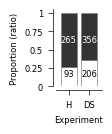

In [5]:
# setup
FIGSIZE = (0.6, 1)
_, ax = plt.subplots(1, 1, figsize=FIGSIZE)

# plot
ax = isolation.plot_unit_isolation_dense_probe(
    ax, df_hv1, df_hv2, df_hv3, df_hs1, df_hs2, df_hs3
)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])

# save figures
plt.savefig(
    "figures/1_sorting_quality/yield/assets/fig5B_dense_unit_isolation.svg",
    **savefig_cfg,
)